<a href="https://colab.research.google.com/github/ifanirmala/sentiment-analyst-instagram-cyberbullying-with-NLP/blob/main/sentiment_analyst_instagram_cyberbullying_with_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import  Library

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
!pip uninstall gensim

Found existing installation: gensim 3.8.3
Uninstalling gensim-3.8.3:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/gensim-3.8.3.dist-info/*
    /usr/local/lib/python3.9/dist-packages/gensim/*
Proceed (Y/n)? n


# Read Dataset

In [ ]:
df = pd.read_csv('/dataset_komentar_instagram_cyberbullying.csv',delimiter=',',encoding='latin-1')
df.head()

,ï»¿Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


# Menghapus baris pertama dan rename

In [ ]:
df = df.drop(['ï»¿Id'], axis=1)

In [ ]:
df = df.rename(columns={'Sentiment':'sentiment','Instagram Comment Text':'Message'})

In [ ]:
df.head()

,sentiment,Message
0,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [ ]:
df.shape

(400, 2)

In [ ]:
df.index = range(400)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

9672

# Visualizing The Data

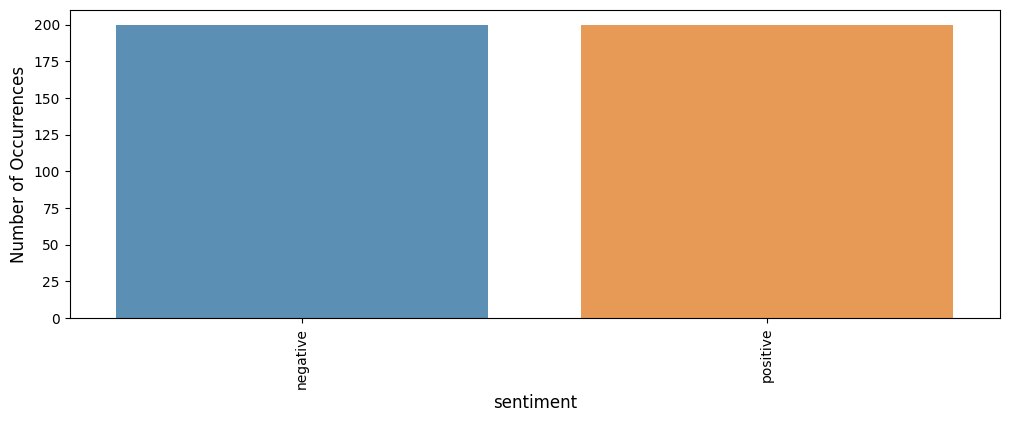

In [ ]:
cnt_pro = df['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [ ]:
#Convert sting to numeric
sentiment  = {'positive': 0,'negative':1}

df.sentiment = [sentiment[item] for item in df.sentiment]
print(df)

     sentiment                                            Message
0            1   <USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1            1  Geblek lo tata...cowo bgt dibela2in balikan......
2            1  Kmrn termewek2 skr lengket lg duhhh kok labil ...
3            1  Intinya kalau kesel dengan ATT nya, gausah ke ...
4            1  hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...
..         ...                                                ...
395          0  Bangga sama suami yg selalu ingat istri disela...
396          0  Apaoun pekerjaannya yg penting halal u tuk men...
397          0  Gojek itu mayoritas pegangguran yang lama gak ...
398          0   <USERNAME> aslinya cantik dan ayu loh mbak kr...
399          0   <USERNAME> suami saya seumuran sama saya mba,...

[400 rows x 2 columns]


In [ ]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

 <USERNAME> eh... Situ siapa??? Kids jaman now ya kebanyakan micin.. Mna kata aku yg ngina??? Bego dipelihara??????
Message: 1


In [ ]:
print_message(0)

 <USERNAME> TOLOL!! Gak ada hubungan nya keguguran dgn pake hijab syar'i yg lo bilang bayi nya kepanasan didalem gak ada hubungan nya woyyyy!! Otak sama jempol lo gak singkron sih ya jadinya asal nulis komentar!
Message: 1


Pemrosesan Teks Di bawah ini mendefinisikan fungsi untuk mengonversi teks menjadi huruf kecil dan menghapus tanda baca/simbol dari kata dan seterusnya.

In [ ]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(cleanText)

<ipython-input-12-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


In [ ]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

<ipython-input-12-aaa97489b476>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Found 400 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (400, 50)


In [ ]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['pembagian', 'suaranya', 'pas', 'bnget', ',', 'pecah', 'suaranya', 'jg', 'cakep'], tags=[0]),
       TaggedDocument(words=['cowok', 'macam', 'anjing', 'cuihhh', '...', 'orang', 'kaya', 'tidak', 'akan', 'pernah', 'berkoar', 'gua', 'orang', 'yang', 'ping', 'kaya', 'sedunia', '...', 'karena', 'semua', 'orang', 'juga', 'tau', 'klo', 'dia', 'orang', 'kaya', '...', 'orang', 'kaya', 'malahn', 'berperilaku', 'sebagai', 'mana', 'orang', 'sederhana', 'buat', 'apa', 'memamerkan', 'kekayaan', 'di', 'dunia', 'di', 'akhirat', 'mampus', 'lu', 'harta', 'kagak', 'akan', 'di', 'bawa', 'mati', 'yang', 'pants', 'di', 'buang', 'ke', 'laut', 'itu', 'lu', 'orang', 'yang', 'paling', 'anehhh'], tags=[1]),
       TaggedDocument(words=['sukak', 'cewe', 'cantik', 'dan', 'kmauan', 'blajarnya', 'tinggi', '?', '?', '?'], tags=[0]),
       TaggedDocument(words=['gue', 'gak', 'suka', 'sm', 'ni', 'orang', '.', 'idupnya', 'kebanyakan', 'ribut', '.'], tags=[1]),
       TaggedDocument(words=['

Model DM = 1

This work use DM=1 (it preserve word order)

In [ ]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 399/399 [00:00<00:00, 1074151.02it/s]


In [ ]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 399/399 [00:00<00:00, 1518627.31it/s]


CPU times: user 1.55 s, sys: 45.2 ms, total: 1.59 s
Wall time: 1.71 s


In [ ]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [ ]:
len(d2v_model.wv.vocab)

3243

In [ ]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

#Mengukur jarak antara dua vektor (terkait dengan cosinus kesamaan)

In [ ]:
d2v_model.wv.most_similar(positive=['cantik'], topn=10)


[('se', 0.9075679779052734),
 ('jawabannya', 0.8285411596298218),
 ('sebenarnya', 0.8151957392692566),
 ('kmauan', 0.8073944449424744),
 ('ancur', 0.8059254884719849),
 ('orangnya', 0.7972463369369507),
 ('akuuu', 0.7939754724502563),
 ('jahatnya', 0.7930676937103271),
 ('pecun.', 0.7921987175941467),
 ('mingkem', 0.7906980514526367)]

In [ ]:
d2v_model.wv.most_similar(positive=['semoga'], topn=10)

[('sehat', 0.9745088815689087),
 ('lacar', 0.9631248712539673),
 ('finally', 0.949293315410614),
 ('juaranya', 0.9490053057670593),
 ('rejekinya', 0.9472116231918335),
 ('ganteng-ganteng', 0.9421280026435852),
 ('ayahnya', 0.9386715888977051),
 ('unggul', 0.9351469278335571),
 ('lekas', 0.9347514510154724),
 ('luck', 0.9304124116897583)]

In [ ]:
d2v_model.wv.most_similar(positive=['bagus'], topn=10)

[('sumpah', 0.9453706741333008),
 ('pupuk', 0.9125020503997803),
 ('dripda', 0.8987951278686523),
 ('jngan', 0.8979023098945618),
 ('mesum', 0.8958648443222046),
 ('bacot', 0.8957103490829468),
 ('video', 0.8902847766876221),
 ('wkwkwkwkw', 0.8897320628166199),
 ('bencong', 0.8871203064918518),
 ('suara', 0.8852367401123047)]

Plot Kesamaan kata di Doc2vec

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in d2v_model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# Buat Model LSTM

Parameter yang digunakan di sini terinspirasi oleh [3].

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding


# init layer
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            64880     
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 79,182
Trainable params: 79,182
Non-trainable params: 0
_________________________________________________________________


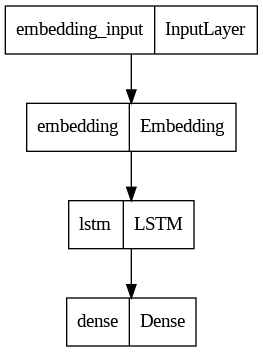

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(340, 50) (340, 2)
(60, 50) (60, 2)


In [ ]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
11/11 - 7s - loss: 0.6935 - acc: 0.5147 - 7s/epoch - 600ms/step
Epoch 2/50
11/11 - 1s - loss: 0.6856 - acc: 0.5471 - 610ms/epoch - 55ms/step
Epoch 3/50
11/11 - 0s - loss: 0.6533 - acc: 0.7500 - 396ms/epoch - 36ms/step
Epoch 4/50
11/11 - 0s - loss: 0.5642 - acc: 0.7706 - 313ms/epoch - 28ms/step
Epoch 5/50
11/11 - 0s - loss: 0.4029 - acc: 0.8824 - 317ms/epoch - 29ms/step
Epoch 6/50
11/11 - 0s - loss: 0.3120 - acc: 0.9912 - 320ms/epoch - 29ms/step
Epoch 7/50
11/11 - 0s - loss: 0.2227 - acc: 0.9971 - 340ms/epoch - 31ms/step
Epoch 8/50
11/11 - 0s - loss: 0.1465 - acc: 0.9912 - 337ms/epoch - 31ms/step
Epoch 9/50
11/11 - 0s - loss: 0.0938 - acc: 0.9941 - 317ms/epoch - 29ms/step
Epoch 10/50
11/11 - 0s - loss: 0.0647 - acc: 0.9971 - 333ms/epoch - 30ms/step
Epoch 11/50
11/11 - 0s - loss: 0.0478 - acc: 1.0000 - 313ms/epoch - 28ms/step
Epoch 12/50
11/11 - 0s - loss: 0.0327 - acc: 1.0000 - 315ms/epoch - 29ms/step
Epoch 13/50
11/11 - 0s - loss: 0.0236 - acc: 1.0000 - 361ms/epoch - 33ms/st

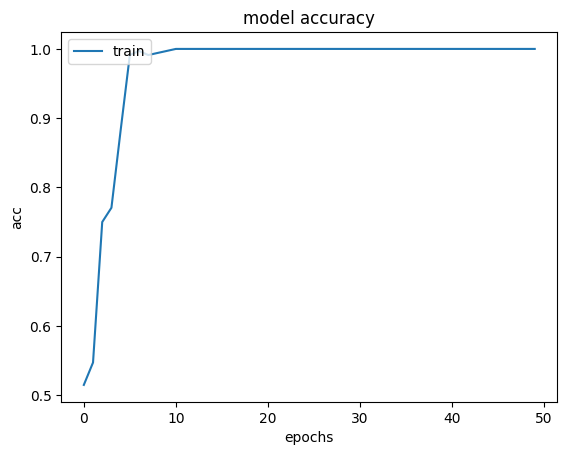

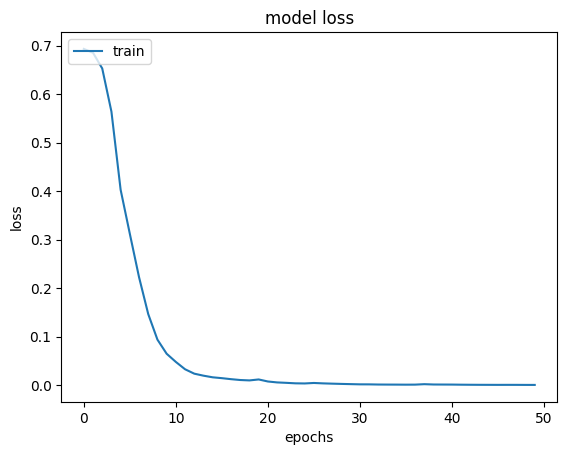

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

11/11 - 1s - loss: 3.4688e-04 - acc: 1.0000 - 694ms/epoch - 63ms/step
2/2 - 0s - loss: 0.6079 - acc: 0.9167 - 44ms/epoch - 22ms/step
Train: 1.000, Test: 0.9167


In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
predict_x=model.predict(X_test)
yhat_classes=np.argmax(predict_x,axis=1)
# yhat_classes = model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[9.9999982e-01 1.5199109e-07]
 [9.9999970e-01 1.8852704e-07]
 [8.8742702e-09 9.9999994e-01]
 [9.9999982e-01 1.2827526e-07]
 [1.8657963e-03 9.9813420e-01]
 [8.1133118e-07 9.9999911e-01]
 [9.9999994e-01 1.9056237e-08]
 [1.1157931e-08 9.9999994e-01]
 [9.9999994e-01 1.2324277e-08]
 [4.8410370e-06 9.9999505e-01]
 [9.9999934e-01 5.4520888e-07]
 [9.9999994e-01 2.9199633e-08]
 [1.0011562e-08 9.9999994e-01]
 [1.4990077e-07 9.9999982e-01]
 [9.9999994e-01 2.8081548e-08]
 [2.9588378e-08 9.9999994e-01]
 [9.9999994e-01 1.7317674e-08]
 [9.9999994e-01 1.4271129e-08]
 [9.9999994e-01 1.7266453e-08]
 [9.9998409e-01 1.5839314e-05]
 [8.3673303e-04 9.9916321e-01]
 [1.1585318e-08 9.9999994e-01]
 [9.9999994e-01 2.5326921e-08]
 [9.9999994e-01 2.8599599e-08]
 [1.1074689e-08 9.9999994e-01]
 [9.9999946e-01 4.8778804e-07]
 [9.4983026e-09 9.9999994e-01]
 [9.9999994e-01 2.3942029e-08]
 [9.7141987e-01 2.8580092e-02]
 [5.6073491e-06 9.9999434e-01]
 [9.9999994e-01 1.6301156e-08]
 [4.2371073e-01 5.7628930e-01]
 [9.9999

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[25,  0],
       [ 5, 30]])

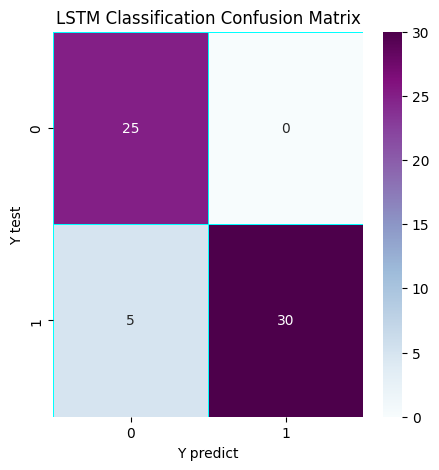

In [ ]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

2/2 [==============================] - 0s 16ms/step - loss: 0.6079 - acc: 0.9167
score: 0.61
acc: 0.92


**Save Model**


In [ ]:
model.save('Mymodel.h5')

**Uji dengan data baru dan berbeda yang disisihkan dari data untuk membuat model.**

catatan : sentimen = {'positif': 0, 'negatif': 1}

In [ ]:
message = ['makasih sayang']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 45ms/step
[[0.9401455  0.05985445]] 0


In [ ]:
message = ['tolol bodoh']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 31ms/step
[[0.3160809 0.6839191]] 1
